Lab work №4

Student name - Khrystyna

Student surname - Zyryanova

Group - CS-32

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Інструменти для Кластеризації
from sklearn.cluster import (
    KMeans, 
    DBSCAN, 
    AgglomerativeClustering, 
    SpectralClustering
)

# Ініціалізація UMAP-об'єктів
umap_2c = umap.UMAP(n_components=2, random_state=42, verbose=False)
umap_3c = umap.UMAP(n_components=3, random_state=42, verbose=False)


# Метрики Оцінки
# DR Quality
from sklearn.manifold import trustworthiness
# без справжніх міток
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
# з використанням справжніх міток
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import fowlkes_mallows_score

%matplotlib inline

In [25]:
# Завантаження датасету Dry Bean 
try:
    df = pd.read_csv("Dry_Bean_Dataset.csv") 
    print("Файл 'Dry_Bean_Dataset.csv' завантажено успішно.")
except FileNotFoundError:
    print("!!! ПОМИЛКА: Файл 'Dry_Bean_Dataset.csv' не знайдено.")
    raise SystemExit("Зупинено: Не вдалося завантажити датасет.")
    
print(f"Кількість записів: {len(df)}")

# 1.1. Відокремлення ознак (X) та цільової змінної (y)
X_data = df.drop(columns="Class")
y_data = df["Class"]

# 1.2. Визначення кількості справжніх класів 
n_classes = len(y_data.unique())
print(f"\nКількість справжніх класів: {n_classes}")

# Конвертація y_data у числові мітки (0, 1, 2, ...)
y_mapping = {label: i for i, label in enumerate(y_data.unique())}
y_numeric = y_data.map(y_mapping).values


# 1.3. Попередня обробка: Масштабування ознак
print("\n### 2. Масштабування ознак (StandardScaler) ###")

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    data=scaler.fit_transform(X_data),
    columns=X_data.columns,
)

# Створення фінальних numpy масивів
X_np = X_scaled.values
y_np = y_numeric

Файл 'Dry_Bean_Dataset.csv' завантажено успішно.
Кількість записів: 13611

Кількість справжніх класів: 7

### 2. Масштабування ознак (StandardScaler) ###


In [26]:
# Функції візуалізації
def plot_2d(X_2d, labels, title="2D Visualization"):
    
    hue_labels = pd.Series(labels).astype(str)
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=X_2d[:, 0], 
        y=X_2d[:, 1],
        hue=hue_labels,
        palette=sns.color_palette("bright", n_colors=len(np.unique(labels))),
        legend="full",
        s=15
    )
    plt.title(title)
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.show()

def plot_3d_plotly(X_3d, labels, title="3D Visualization"):
  
    df = pd.DataFrame({
        'Component 1': X_3d[:, 0],
        'Component 2': X_3d[:, 1],
        'Component 3': X_3d[:, 2],
        'label': labels
    })
    
    df['label'] = df['label'].astype(str)
    
    fig = px.scatter_3d(
        df, 
        x='Component 1', 
        y='Component 2', 
        z='Component 3',
        color='label',  
        title=title
    )
    
    fig.update_traces(marker=dict(size=1))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
    fig.show()

# Функція оцінки кластеризації
def evaluate_clustering(X, labels, true_labels, model=None, algorithm_info="Clustering"):

    results = {}
    
    # Фільтрація викидів
    is_core_mask = (labels != -1)
    has_outliers = not np.all(is_core_mask)
    X_core = X[is_core_mask]
    labels_core = labels[is_core_mask]
    
    results['algorithm'] = algorithm_info
    
    # Метрики DBSCAN / Кількість кластерів
    if has_outliers:
        n_clusters = len(np.unique(labels_core))
        n_outliers = np.sum(~is_core_mask)
        results['num_clusters'] = n_clusters
        results['num_outliers'] = n_outliers
    else:
        n_clusters = len(np.unique(labels))
        results['num_clusters'] = n_clusters

    if 1 < n_clusters < X_core.shape[0]:
        results['silhouette_score (1 - краще)'] = silhouette_score(X_core, labels_core)
        results['davies_bouldin_index (нижче - краще)'] = davies_bouldin_score(X_core, labels_core)
        results['calinski_harabasz_score (вище - краще)'] = calinski_harabasz_score(X_core, labels_core)
    else:
        results['silhouette_score (1 - краще)'] = None
        results['davies_bouldin_index (нижче - краще)'] = None
        results['calinski_harabasz_score (вище - краще)'] = None
        
    # Спеціальна метрика k-means WCSS
    if model is not None and hasattr(model, 'inertia_'):
        results['wcss_inertia'] = model.inertia_

    # Зі справжніми мітками
    if true_labels is not None:
        results['nmi (1 - ідеал)'] = normalized_mutual_info_score(true_labels, labels)
        results['ari (1 - ідеал)'] = adjusted_rand_score(true_labels, labels)
        results['fmi (1 - ідеал)'] = fowlkes_mallows_score(true_labels, labels)
        
    return results

# Ініціалізація списку для збору всіх результатів
all_results = []

In [27]:
# K-Means Clustering (K=7)
K = n_classes 
print(f"### K-Means (K={K}) на оригінальних даних ###")
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_np)

k_means_results = evaluate_clustering(
    X_np, 
    kmeans_labels, 
    y_np, 
    model=kmeans, 
    algorithm_info=f"K-Means (K={K}) Original Data"
)
all_results.append(k_means_results)
print(pd.Series(k_means_results).to_frame(name="Оцінка K-Means"))

### K-Means (K=7) на оригінальних даних ###
                                                     Оцінка K-Means
algorithm                               K-Means (K=7) Original Data
num_clusters                                                      7
silhouette_score (1 - краще)                                0.30938
davies_bouldin_index (нижче - краще)                       1.099301
calinski_harabasz_score (вище - краще)                  7848.441986
wcss_inertia                                           48811.956417
nmi (1 - ідеал)                                            0.713764
ari (1 - ідеал)                                            0.668696
fmi (1 - ідеал)                                            0.727555


In [28]:
# Spectral Clustering (K=7)
print(f"\n### Spectral Clustering (K={K}) на оригінальних даних ###")
spectral = SpectralClustering(
    n_clusters=K,
    affinity='rbf', 
    gamma=1.0,      
    random_state=42,
    n_init=10,
    assign_labels='kmeans' 
)
spectral_labels = spectral.fit_predict(X_np)

spectral_results = evaluate_clustering(
    X_np, 
    spectral_labels, 
    y_np, 
    algorithm_info=f"Spectral Clustering (K={K}) Original Data"
)
all_results.append(spectral_results)
print(pd.Series(spectral_results).to_frame(name="Оцінка Spectral"))


### Spectral Clustering (K=7) на оригінальних даних ###
                                                                Оцінка Spectral
algorithm                               Spectral Clustering (K=7) Original Data
num_clusters                                                                  7
silhouette_score (1 - краще)                                           0.470296
davies_bouldin_index (нижче - краще)                                   1.081499
calinski_harabasz_score (вище - краще)                               794.439594
nmi (1 - ідеал)                                                        0.166975
ari (1 - ідеал)                                                        0.033517
fmi (1 - ідеал)                                                        0.430982


In [29]:
# Agglomerative Clustering (K=7)
print(f"\n### Agglomerative Clustering (K={K}) на оригінальних даних ###")
agglomerative = AgglomerativeClustering(
    n_clusters=K,
    linkage='ward' 
)
agglomerative_labels = agglomerative.fit_predict(X_np)

agglomerative_results = evaluate_clustering(
    X_np, 
    agglomerative_labels, 
    y_np, 
    algorithm_info=f"Agglomerative Clustering (K={K}) Original Data"
)
all_results.append(agglomerative_results)
print(pd.Series(agglomerative_results).to_frame(name="Оцінка Agglomerative"))


### Agglomerative Clustering (K=7) на оригінальних даних ###
                                                                Оцінка Agglomerative
algorithm                               Agglomerative Clustering (K=7) Original Data
num_clusters                                                                       7
silhouette_score (1 - краще)                                                0.283855
davies_bouldin_index (нижче - краще)                                        1.106442
calinski_harabasz_score (вище - краще)                                   6981.274499
nmi (1 - ідеал)                                                             0.732529
ari (1 - ідеал)                                                             0.657985
fmi (1 - ідеал)                                                             0.721948


In [30]:
# DBSCAN Clustering
print("\n### DBSCAN Clustering на оригінальних даних (Тюнінг) ###")
MinPts = 32
Eps = 0.9

dbscan = DBSCAN(eps=Eps, min_samples=MinPts)
dbscan_labels = dbscan.fit_predict(X_np)

dbscan_results = evaluate_clustering(
    X_np, 
    dbscan_labels, 
    y_np, 
    algorithm_info=f"DBSCAN (MinPts={MinPts}, Eps={Eps}) Original Data"
)
all_results.append(dbscan_results)
print(pd.Series(dbscan_results).to_frame(name="Оцінка DBSCAN"))


### DBSCAN Clustering на оригінальних даних (Тюнінг) ###
                                                                    Оцінка DBSCAN
algorithm                               DBSCAN (MinPts=32, Eps=0.9) Original Data
num_clusters                                                                    3
num_outliers                                                                 2934
silhouette_score (1 - краще)                                             0.242154
davies_bouldin_index (нижче - краще)                                     0.971129
calinski_harabasz_score (вище - краще)                                2179.179751
nmi (1 - ідеал)                                                          0.369961
ari (1 - ідеал)                                                          0.205596
fmi (1 - ідеал)                                                          0.470317


### 1. PCA: Зниження Розмірності ###
PCA 2D: Пояснена дисперсія = 0.8190
PCA 3D: Пояснена дисперсія = 0.8990


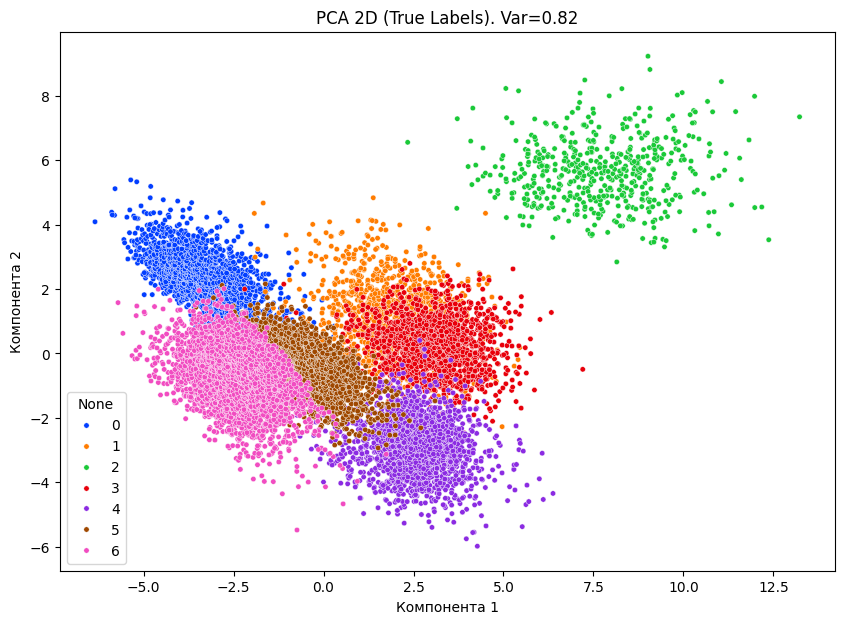

In [31]:
print("### 1. PCA: Зниження Розмірності ###")
# Застосування PCA
pca_2c = PCA(n_components=2, random_state=42)
pca_3c = PCA(n_components=3, random_state=42)

X_pca_2d = pca_2c.fit_transform(X_np)
X_pca_3d = pca_3c.fit_transform(X_np)

# Оцінка якості DR
pca_variance_2d = np.sum(pca_2c.explained_variance_ratio_)
pca_variance_3d = np.sum(pca_3c.explained_variance_ratio_)

print(f"PCA 2D: Пояснена дисперсія = {pca_variance_2d:.4f}")
print(f"PCA 3D: Пояснена дисперсія = {pca_variance_3d:.4f}")

# Візуалізація
plot_2d(X_pca_2d, y_np, title=f"PCA 2D (True Labels). Var={pca_variance_2d:.2f}")
plot_3d_plotly(X_pca_3d, y_np, title=f"PCA 3D (True Labels). Var={pca_variance_3d:.2f}")


### 2. t-SNE: Зниження Розмірності ###
t-SNE 2D: Trustworthiness = 0.9982
t-SNE 3D: Trustworthiness = 0.9990


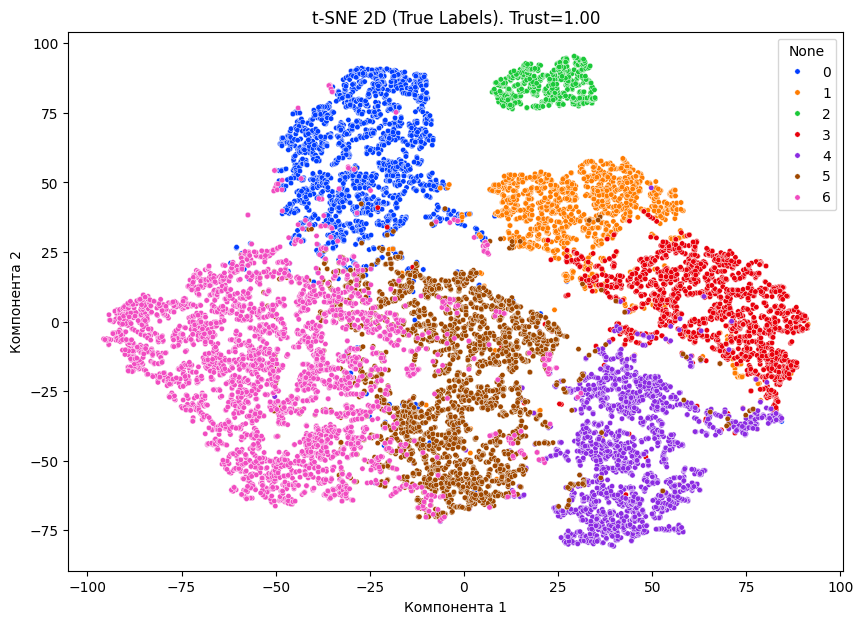

In [33]:
print("\n### 2. t-SNE: Зниження Розмірності ###")
tsne_2c = TSNE(n_components=2, random_state=42, n_jobs=-1, perplexity=30.0)
tsne_3c = TSNE(n_components=3, random_state=42, n_jobs=-1, perplexity=30.0)

X_tsne_2d = tsne_2c.fit_transform(X_np)
X_tsne_3d = tsne_3c.fit_transform(X_np)

# Оцінка якості DR
tsne_trust_2d = trustworthiness(X_np, X_tsne_2d, n_neighbors=10)
tsne_trust_3d = trustworthiness(X_np, X_tsne_3d, n_neighbors=10)

print(f"t-SNE 2D: Trustworthiness = {tsne_trust_2d:.4f}")
print(f"t-SNE 3D: Trustworthiness = {tsne_trust_3d:.4f}")

# Візуалізація
plot_2d(X_tsne_2d, y_np, title=f"t-SNE 2D (True Labels). Trust={tsne_trust_2d:.2f}")
plot_3d_plotly(X_tsne_3d, y_np, title=f"t-SNE 3D (True Labels). Trust={tsne_trust_3d:.2f}")


### 3. UMAP: Зниження Розмірності ###
UMAP 2D: Trustworthiness = 0.9772
UMAP 3D: Trustworthiness = 0.9932


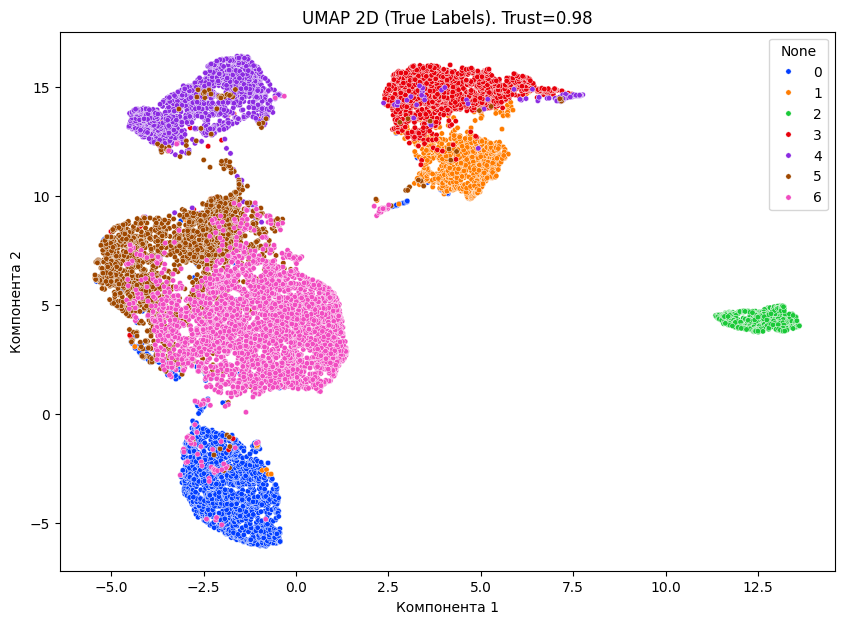

In [35]:
print("\n### 3. UMAP: Зниження Розмірності ###")

X_umap_2d = umap_2c.fit_transform(X_np)
X_umap_3d = umap_3c.fit_transform(X_np)

# Оцінка якості DR
umap_trust_2d = trustworthiness(X_np, X_umap_2d, n_neighbors=10)
umap_trust_3d = trustworthiness(X_np, X_umap_3d, n_neighbors=10)

print(f"UMAP 2D: Trustworthiness = {umap_trust_2d:.4f}")
print(f"UMAP 3D: Trustworthiness = {umap_trust_3d:.4f}")

# Візуалізація
plot_2d(X_umap_2d, y_np, title=f"UMAP 2D (True Labels). Trust={umap_trust_2d:.2f}")
plot_3d_plotly(X_umap_3d, y_np, title=f"UMAP 3D (True Labels). Trust={umap_trust_3d:.2f}")

In [36]:
# K-Means Clustering на PCA 3D
K = n_classes
print(f"### K-Means (K={K}) на PCA-3D даних ###")
kmeans_pca = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans_pca_labels = kmeans_pca.fit_predict(X_pca_3d)

# Візуалізація кластерів K-Means на PCA
plot_3d_plotly(X_pca_3d, kmeans_pca_labels, title=f"PCA 3D (K-Means K={K} Clusters)")

# Оцінка
kmeans_pca_results = evaluate_clustering(
    X_pca_3d, 
    kmeans_pca_labels, 
    y_np, 
    model=kmeans_pca, 
    algorithm_info=f"K-Means (K={K}) PCA-3D Data"
)
all_results.append(kmeans_pca_results)
print(pd.Series(kmeans_pca_results).to_frame(name="Оцінка"))

### K-Means (K=7) на PCA-3D даних ###


                                                           Оцінка
algorithm                               K-Means (K=7) PCA-3D Data
num_clusters                                                    7
silhouette_score (1 - краще)                             0.387302
davies_bouldin_index (нижче - краще)                     0.880709
calinski_harabasz_score (вище - краще)               12276.021294
wcss_inertia                                         30524.146672
nmi (1 - ідеал)                                          0.707519
ari (1 - ідеал)                                           0.66653
fmi (1 - ідеал)                                          0.725978


In [37]:
# K-Means Clustering на UMAP 3D
K = n_classes
print(f"\n### K-Means (K={K}) на UMAP-3D даних ###")
kmeans_umap = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans_umap_labels = kmeans_umap.fit_predict(X_umap_3d)

# Візуалізація кластерів K-Means на UMAP
plot_3d_plotly(X_umap_3d, kmeans_umap_labels, title=f"UMAP 3D (K-Means K={K} Clusters)")

# Оцінка
kmeans_umap_results = evaluate_clustering(
    X_umap_3d, 
    kmeans_umap_labels, 
    y_np, 
    model=kmeans_umap, 
    algorithm_info=f"K-Means (K={K}) UMAP-3D Data"
)
all_results.append(kmeans_umap_results)
print(pd.Series(kmeans_umap_results).to_frame(name="Оцінка"))


### K-Means (K=7) на UMAP-3D даних ###


                                                            Оцінка
algorithm                               K-Means (K=7) UMAP-3D Data
num_clusters                                                     7
silhouette_score (1 - краще)                               0.54266
davies_bouldin_index (нижче - краще)                      0.624669
calinski_harabasz_score (вище - краще)                31778.177734
wcss_inertia                                          31646.283203
nmi (1 - ідеал)                                           0.786674
ari (1 - ідеал)                                           0.759206
fmi (1 - ідеал)                                           0.800741


Висновок:

Для кластеризації датасету Dry Bean найкращий результат досягнуто комбінацією UMAP (3D) та K-Means. UMAP значно підвищив якість кластеризації (ARI/NMI) у порівнянні з оригінальними даними та перевершив PCA, оскільки його здатність зберігати нелінійну локальну структуру ефективно оптимізувала простір для центроїдного алгоритму K-Means.